## _*QAOA; using its callback to monitor optimization progress*_

This notebook demonstrates using Qiskit Aqua's QAOA algorithm to plot graphs of the convergence path to ground state energy with different optimizers.

This notebook uses the callback capability of QAOA to capture information at each objective functional evaluation where it is computing the energy using the parameterized variational form. While the params themselves are also part of the callback we are only interested in the energy value here to plot the convergence. 

Note: other variational algorithms such as VQE and QSVM have similar callbacks.

In [13]:
import numpy as np
import pylab

from qiskit import BasicAer
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver, QAOA
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal

In [2]:
import qiskit
from docplex.mp.model import Model
from qiskit import Aer
from qiskit.aqua.algorithms import VQE, ExactEigensolver,NumPyEigensolver
from qiskit.aqua.components.optimizers import SPSA, COBYLA
from qiskit.circuit.library import RealAmplitudes #(uses CX entangling) 
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.circuit.library import TwoLocal
#from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions.simulator import Snapshot
from qiskit.extensions.simulator.snapshot import snapshot

from docplex.mp.model import Model
from qiskit.optimization import QuadraticProgram
from qiskit.tools.visualization import plot_histogram
from qiskit.optimization.applications.ising import docplex

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx
import pandas as pd

In [3]:
def CSVtoNumpyArray(rawdata):
    """
    Input: 
    rawdata = a csv file (insert name as a string)

    Output:
    two numpy matrices in a tuple
    """
    data = pd.read_csv(rawdata)  #Reads the data in as a pandas object
    c = data.columns
    column = int(c[0])
    final_data1 = data.iloc[:column,:].values  #Sets data into a series of numpy arrays of strings
    final_data2 = data.iloc[column:,:].values  #1 is for the first matrix(loc) and 2 is for the second(flow)
    

    #Forms the matrix as a numpy array (easier to work with) instead of an list of lists of strings
    def string_to_integers(final_data):
        matrix = []
        for j in range(column):
            string = final_data[j][0]
            string2 = string.split(" ")
            emptyarray = []
            for i in string2:
                if i != '':
                    emptyarray.append(int(i))
            matrix.append(emptyarray)
        npmatrix = np.array(matrix) 
        return npmatrix
    return string_to_integers(final_data1),string_to_integers(final_data2)

In [4]:
#small sized matrices(under 10x10) (quick on all methods)
matrix_size_3 = 'made3.csv'
matrix_size_4 = 'made4.csv'
matrix_size_5 = 'made5.csv'
matrix_size_6 = 'made6.csv'
matrix_size_7 = 'made7.csv'
matrix_size_8 = 'made8.csv'
matrix_size_9 = 'made9.csv'


In [5]:
def qap_value(z, MatrixLoc, MatrixFlow):
    """Compute the TSP value of a solution.
    Args:
        z (list[int]): list of allocations
        MatrixLoc (numpy array): matrix of distances
        MatrixFlow (numpy array): matrix of flow
    Returns:
        float: value of the QAP
    """
    matrix_length = len(MatrixLoc)
    x = np.reshape(z, (matrix_length,matrix_length))
    
    total = 0
    for i in range(matrix_length):
        for j in range(matrix_length):
            for k in range(matrix_length):
                for p in range(matrix_length):
                        total += MatrixLoc[i,j]* MatrixFlow[k,p]*x[i,k]*x[j,p]
    
    return total

In [6]:
from qiskit import IBMQ

# Load account from disk
IBMQ.load_account()
IBMQ.providers()

C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-wits', group='internal', project='physics')>,
 <AccountProvider for IBMQ(hub='ibm-q-wits', group='internal', project='wits-eie')>]

In [7]:
provider = IBMQ.get_provider(hub='ibm-q-wits', group='internal', project='physics')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-wits', group='internal', project='physics')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-wits', group='internal', project='physics')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-wits', group='internal', project='physics')>,
 <IBMQBackend('ibmq_boeblingen') from IBMQ(hub='ibm-q-wits', group='internal', project='physics')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-wits', group='internal', project='physics')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-wits', group='internal', project='physics')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q-wits', group='internal', project='physics')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-wits', group='internal', project='physics')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q-wits', group='internal', project='physics')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q-wits', group='internal', project='physics')>,
 <IBMQBackend('ibmq_toront

In [8]:
def qap_feasible(x):
    """Check whether a solution is feasible or not.

    Args:
        x (numpy.ndarray) : binary string as numpy array.

    Returns:
        bool: feasible or not.
    """
    n = int(np.sqrt(len(x)))
    y = np.reshape(x, (n,n))
   
    for i in range(n):
        if sum(y[i, p] for p in range(n)) != 1:
            return False
    for p__ in range(n):
        if sum(y[i, p__] for i in range(n)) != 1:
            return False
    return True

In [9]:
def choose_best_feasible(eigenstates):
    """
    Input:
    eigenstates = dictionary
    
    Output:
    feasible binary 1D numpyarray
    probability of this answer
    
    """
    bestinarray = sorted(eigenstates.items(), key=lambda item: item[1])[::-1]
    feasible = False
    counter = 0
    total = sum(eigenstates.values())
    final = np.array([0,0])
    
    while counter<len(bestinarray):
        #string to array
        bestasint = np.array([0])
        for i in bestinarray[counter][0]:
            bestasint = np.hstack((bestasint, int(i)))
        feasible = qap_feasible(bestasint[1:])
        if feasible ==True:
            frequency = bestinarray[counter][1]
            final = np.vstack((final,[bestasint[1:], frequency/total]))
            feasible = False
        counter += 1
    return final[1:]

First we create a qubit operator for VQE. Here we have taken a set of paulis that were originally computed by qiskit-chemistry for an H2 molecule.

In [11]:
ins = matrix_size_3
#get matrix
datamatrix = CSVtoNumpyArray(ins)
MatrixLoc = datamatrix[0]
MatrixFlow = datamatrix[1]
n = len(MatrixLoc)

# Create an instance of a model and variables.
thename = "qap" + str(n)
mdl = Model(name=thename)
x = {(i,p): mdl.binary_var(name='x_{0}_{1}'.format(i,p)) for i in range(n) for p in range(n)}

# Object function
qap_func = mdl.sum(MatrixLoc[i,j]* MatrixFlow[k,p]*x[i,k]*x[j,p] for i in range(n) for j in range(n) for p in range(n) for k in range(n))
mdl.minimize(qap_func)

# Constraints
for i in range(n):
    mdl.add_constraint(mdl.sum(x[(i,p)] for p in range(n)) == 1)
for p in range(n):
    mdl.add_constraint(mdl.sum(x[(i,p)] for i in range(n)) == 1)
print(mdl.export_to_string())
qubit_op, offset_docplex = docplex.get_operator(mdl) 


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: qap3

Minimize
 obj: [ 4704 x_0_0*x_1_1 + 3444 x_0_0*x_1_2 + 21280 x_0_0*x_2_1
      + 15580 x_0_0*x_2_2 + 4704 x_0_1*x_1_0 + 504 x_0_1*x_1_2
      + 21280 x_0_1*x_2_0 + 2280 x_0_1*x_2_2 + 3444 x_0_2*x_1_0
      + 504 x_0_2*x_1_1 + 15580 x_0_2*x_2_0 + 2280 x_0_2*x_2_1
      + 18368 x_1_0*x_2_1 + 13448 x_1_0*x_2_2 + 18368 x_1_1*x_2_0
      + 1968 x_1_1*x_2_2 + 13448 x_1_2*x_2_0 + 1968 x_1_2*x_2_1 ]/2
Subject To
 c1: x_0_0 + x_0_1 + x_0_2 = 1
 c2: x_1_0 + x_1_1 + x_1_2 = 1
 c3: x_2_0 + x_2_1 + x_2_2 = 1
 c4: x_0_0 + x_1_0 + x_2_0 = 1
 c5: x_0_1 + x_1_1 + x_2_1 = 1
 c6: x_0_2 + x_1_2 + x_2_2 = 1

Bounds
 0 <= x_0_0 <= 1
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_1 <= 1
 0 <= x_1_2 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_1 <= 1
 0 <= x_2_2 <= 1

Binaries
 x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2
End



Now we loop over the set of optimizers. The defaults for maxiters/evals for the respective optimizers is more than sufficient to converge the above H2 problem so we do not need to add any logic to set accordingly.

In [21]:
optimizers = [COBYLA, L_BFGS_B, SLSQP,SPSA]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
num_qubits = qubit_op.num_qubits

for i in range(len(optimizers)):
    aqua_globals.random_seed = 250
    optimizer = optimizers[i]()
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    #init_state = Zero(num_qubits)
    #var_form = TwoLocal(num_qubits, 'ry', 'cz', initial_state=init_state)

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
  
    algo = QAOA(qubit_op, optimizer,5, callback=store_intermediate_result)
    backend = BasicAer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend=backend)  
    algo_result = algo.run(quantum_instance)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ');

Optimization complete      


Now from the callback data we stored we can plot the energy value at each objective function call each optimzer makes. An optimizer using a finite difference method for computing gradient has that characteristic step like plot where for a number of evaluations it is computing the value for close by points to establish a gradient (the close by points having very similiar values whose difference cannot be seen on the scale of the graph here).

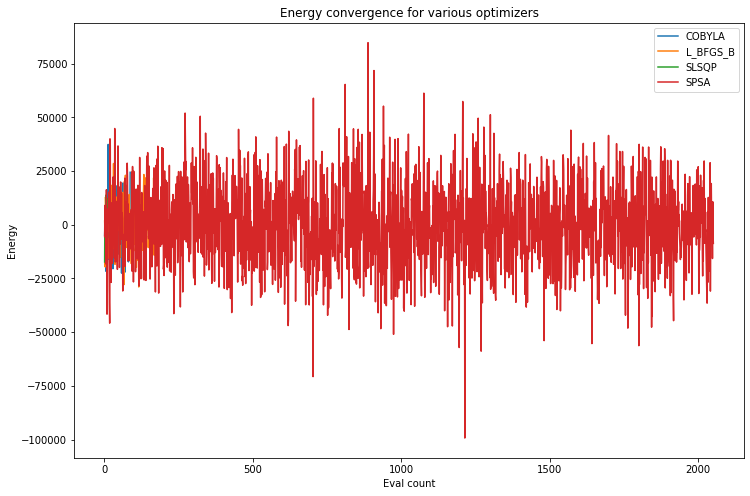

In [22]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(len(optimizers)):
    pylab.plot(converge_cnts[i], converge_vals[i], label=optimizers[i].__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right')

Finally since the above problem is still easily tractable classically we can use NumPyMinimumEigensolver to compute a reference value for the solution. We can now plot the difference from the resultant exact solution as the energy converges with VQE towards the minimum value which should be that exact classical solution.

In [23]:
ee = NumPyMinimumEigensolver(qubit_op)
result = ee.run()
ref = result.eigenvalue.real
print('Reference value: {}'.format(ref))

Reference value: -499640.0


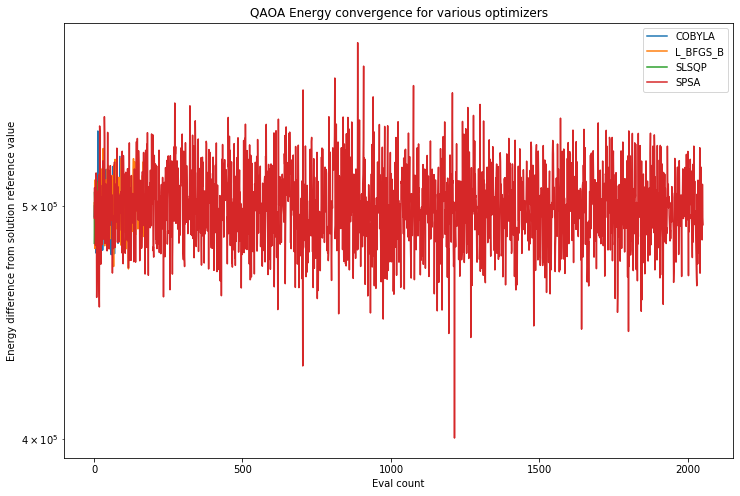

In [29]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(len(optimizers)):
    pylab.plot(converge_cnts[i], abs(ref - converge_vals[i]), label=optimizers[i].__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('QAOA Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right')
plt.savefig("qaoagraph.jpeg")

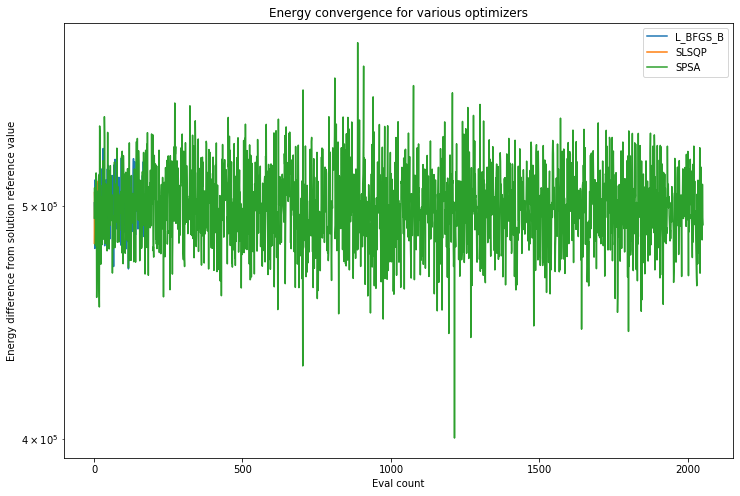

In [25]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(1,len(optimizers),1):
    pylab.plot(converge_cnts[i], abs(ref - converge_vals[i]), label=optimizers[i].__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right')

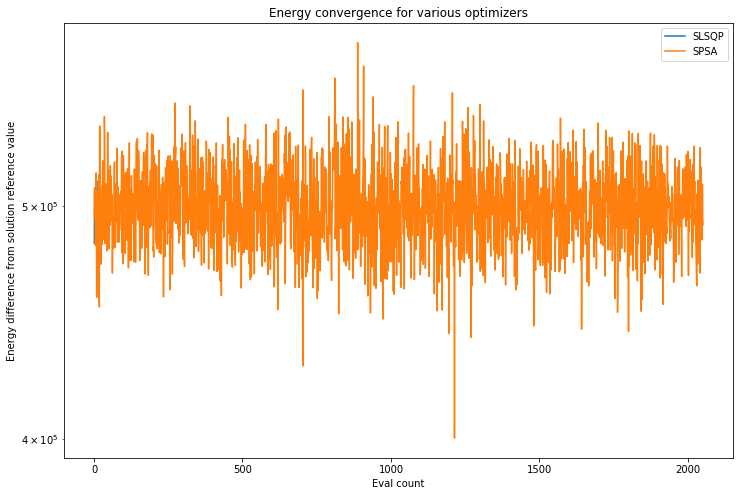

In [26]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(2,len(optimizers),1):
    pylab.plot(converge_cnts[i], abs(ref - converge_vals[i]), label=optimizers[i].__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right')

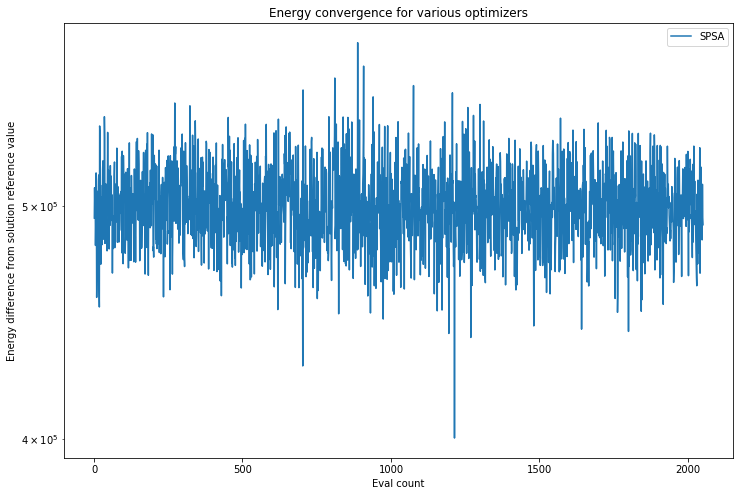

In [27]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(3,len(optimizers),1):
    pylab.plot(converge_cnts[i], abs(ref - converge_vals[i]), label=optimizers[i].__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right')